<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 05 &mdash; Generated Data**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Simple Example

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [2]:
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch import inf


In [3]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [4]:
x = np.linspace(-2, 2, 500)

In [5]:
def f(x):
    return x ** 3

In [6]:
y = f(x)

In [7]:
scaler = StandardScaler()

In [8]:
y_ = scaler.fit_transform(y.reshape(-1, 1))

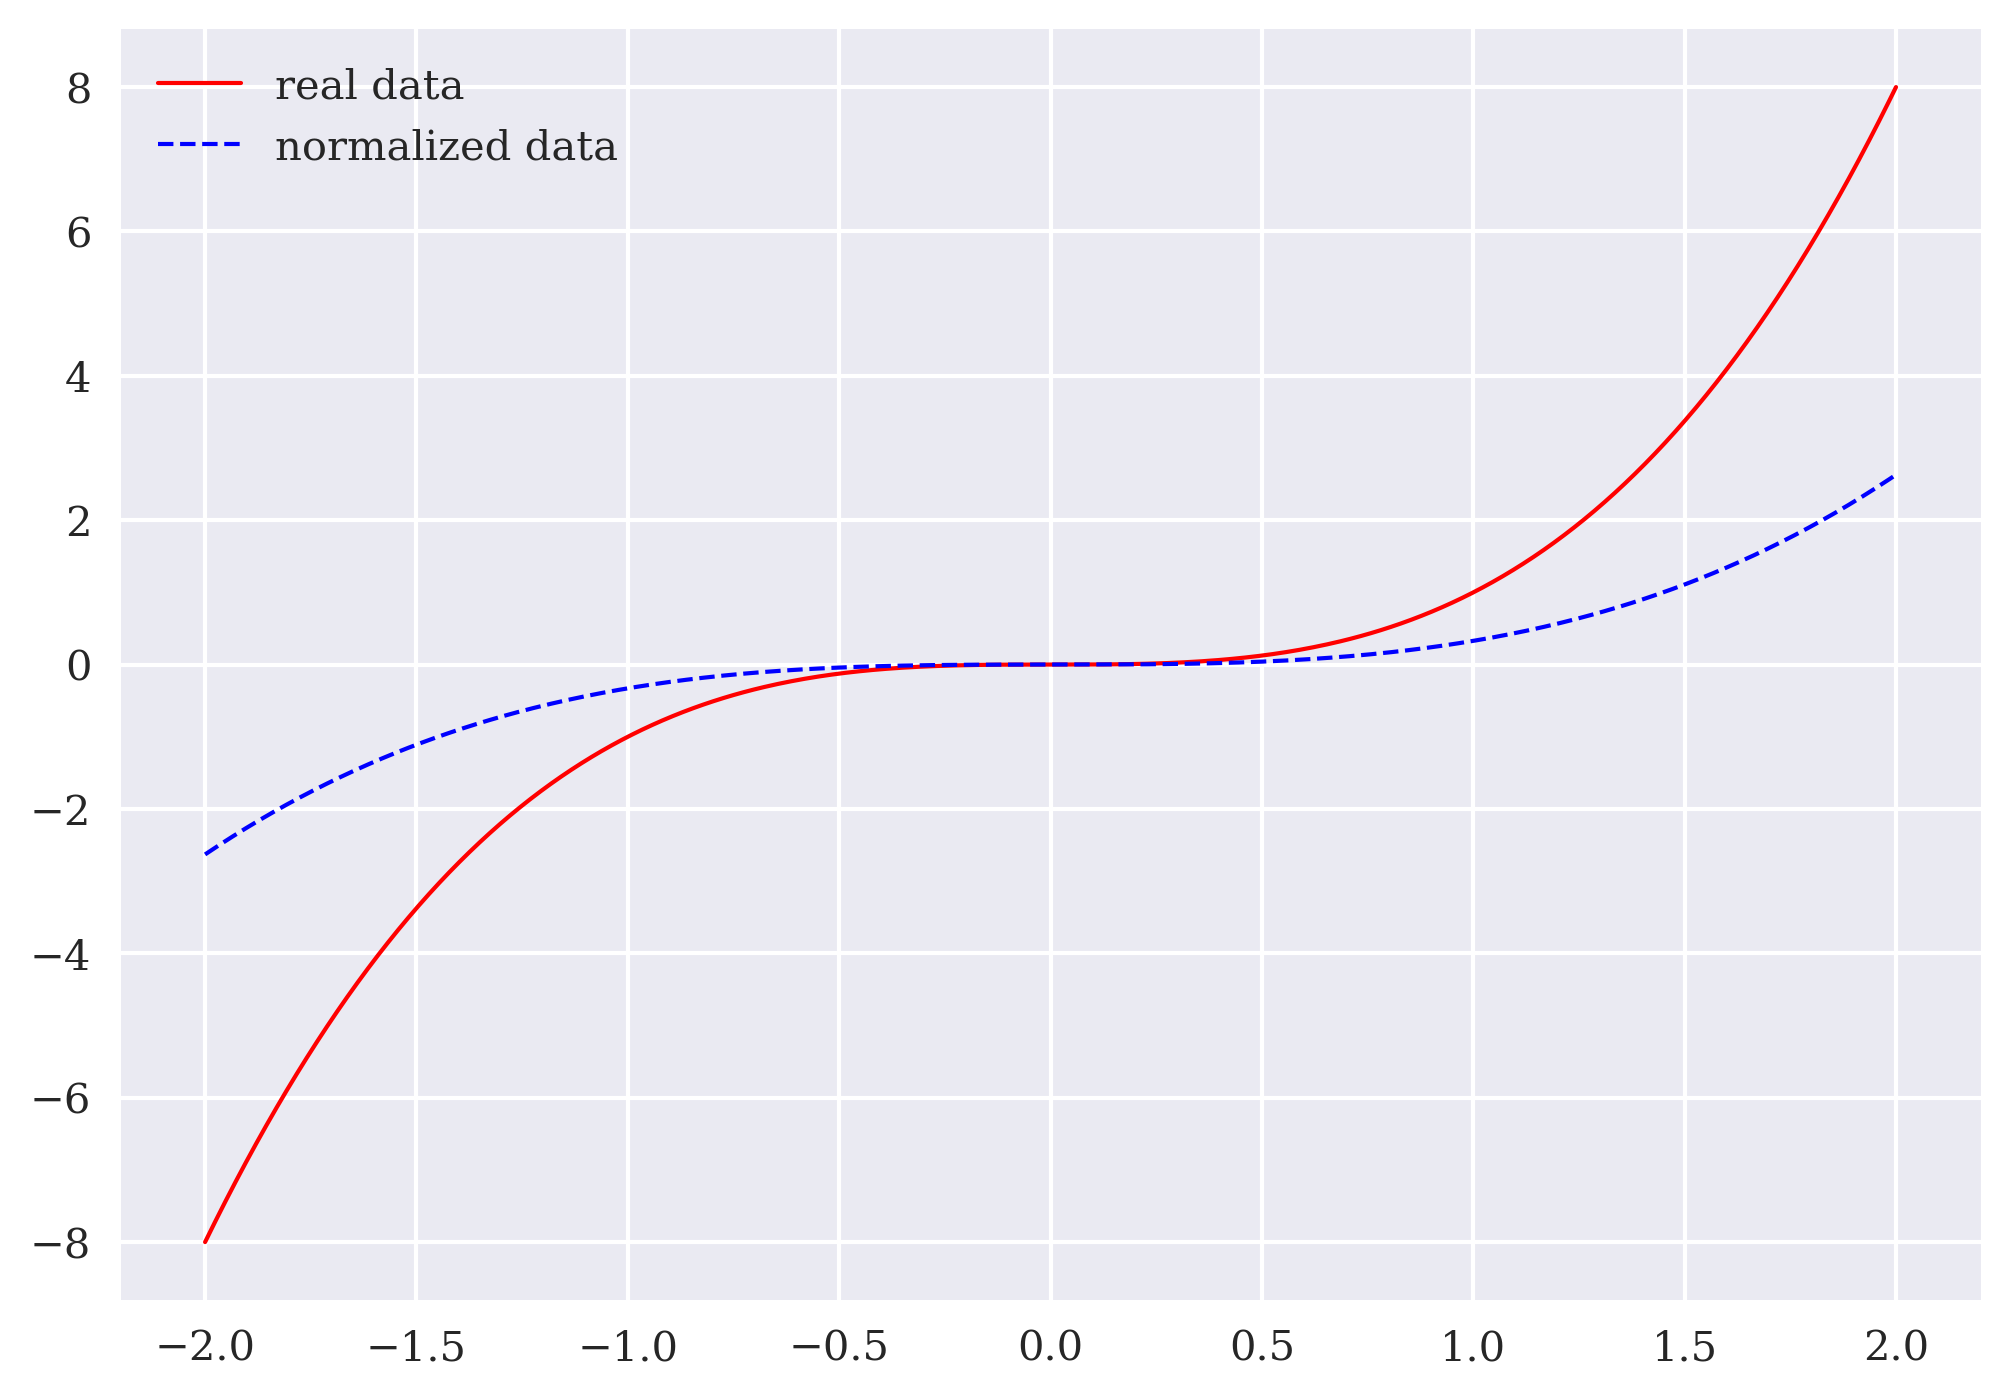

In [9]:
plt.plot(x, y, 'r', lw=1.0,
         label='real data')
plt.plot(x, y_, 'b--', lw=1.0,
         label='normalized data')
plt.legend();

### Model Training

In [10]:
class Generator(nn.Module):
    def __init__(self, hu=32):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hu),
            nn.ReLU(),
            nn.Linear(hu, hu),
            nn.ReLU(),
            nn.Linear(hu, 1)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, hu=32):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hu),
            nn.ReLU(),
            nn.Linear(hu, hu),
            nn.ReLU(),
            nn.Linear(hu, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [12]:
def create_gan(generator, discriminator, lr=0.001):
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    criterion = nn.BCELoss()
    return gen_optimizer, disc_optimizer, criterion

In [13]:
generator = Generator()
discriminator = Discriminator()
gen_optimizer, disc_optimizer, criterion = create_gan(generator, discriminator, lr=0.0001)

In [14]:
from numpy.random import default_rng

In [15]:
rng = default_rng(seed=100)

In [16]:
def train_models(y_, epochs, batch_size):
    for epoch in range(epochs):
        # sample real data
        idx = rng.integers(0, len(y_), batch_size)
        real_batch = torch.from_numpy(y_[idx].reshape(-1, 1)).float()
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # generate fake data
        noise = torch.randn(batch_size, 1)
        fake_batch = generator(noise)

        # train discriminator
        disc_optimizer.zero_grad()
        real_preds = discriminator(real_batch)
        real_loss = criterion(real_preds, real_labels)
        fake_preds = discriminator(fake_batch.detach())
        fake_loss = criterion(fake_preds, fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        disc_optimizer.step()

        # train generator
        gen_optimizer.zero_grad()
        noise = torch.randn(batch_size, 1)
        fake_batch = generator(noise)
        gen_preds = discriminator(fake_batch)
        g_loss = criterion(gen_preds, real_labels)
        g_loss.backward()
        gen_optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}')
    # after training, generate final data
    with torch.no_grad():
        idx = rng.integers(0, len(y_), batch_size)
        real_data = y_[idx]
        synthetic_data = generator(torch.randn(batch_size, 1)).cpu().numpy()
    return real_data, synthetic_data

In [17]:
%%time
real_data, synthetic_data = train_models(y_, epochs=15001, batch_size=32)

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
Epoch: 6000
Epoch: 7000
Epoch: 8000
Epoch: 9000
Epoch: 10000
Epoch: 11000
Epoch: 12000
Epoch: 13000
Epoch: 14000
Epoch: 15000
CPU times: total: 30.8 s
Wall time: 36.5 s


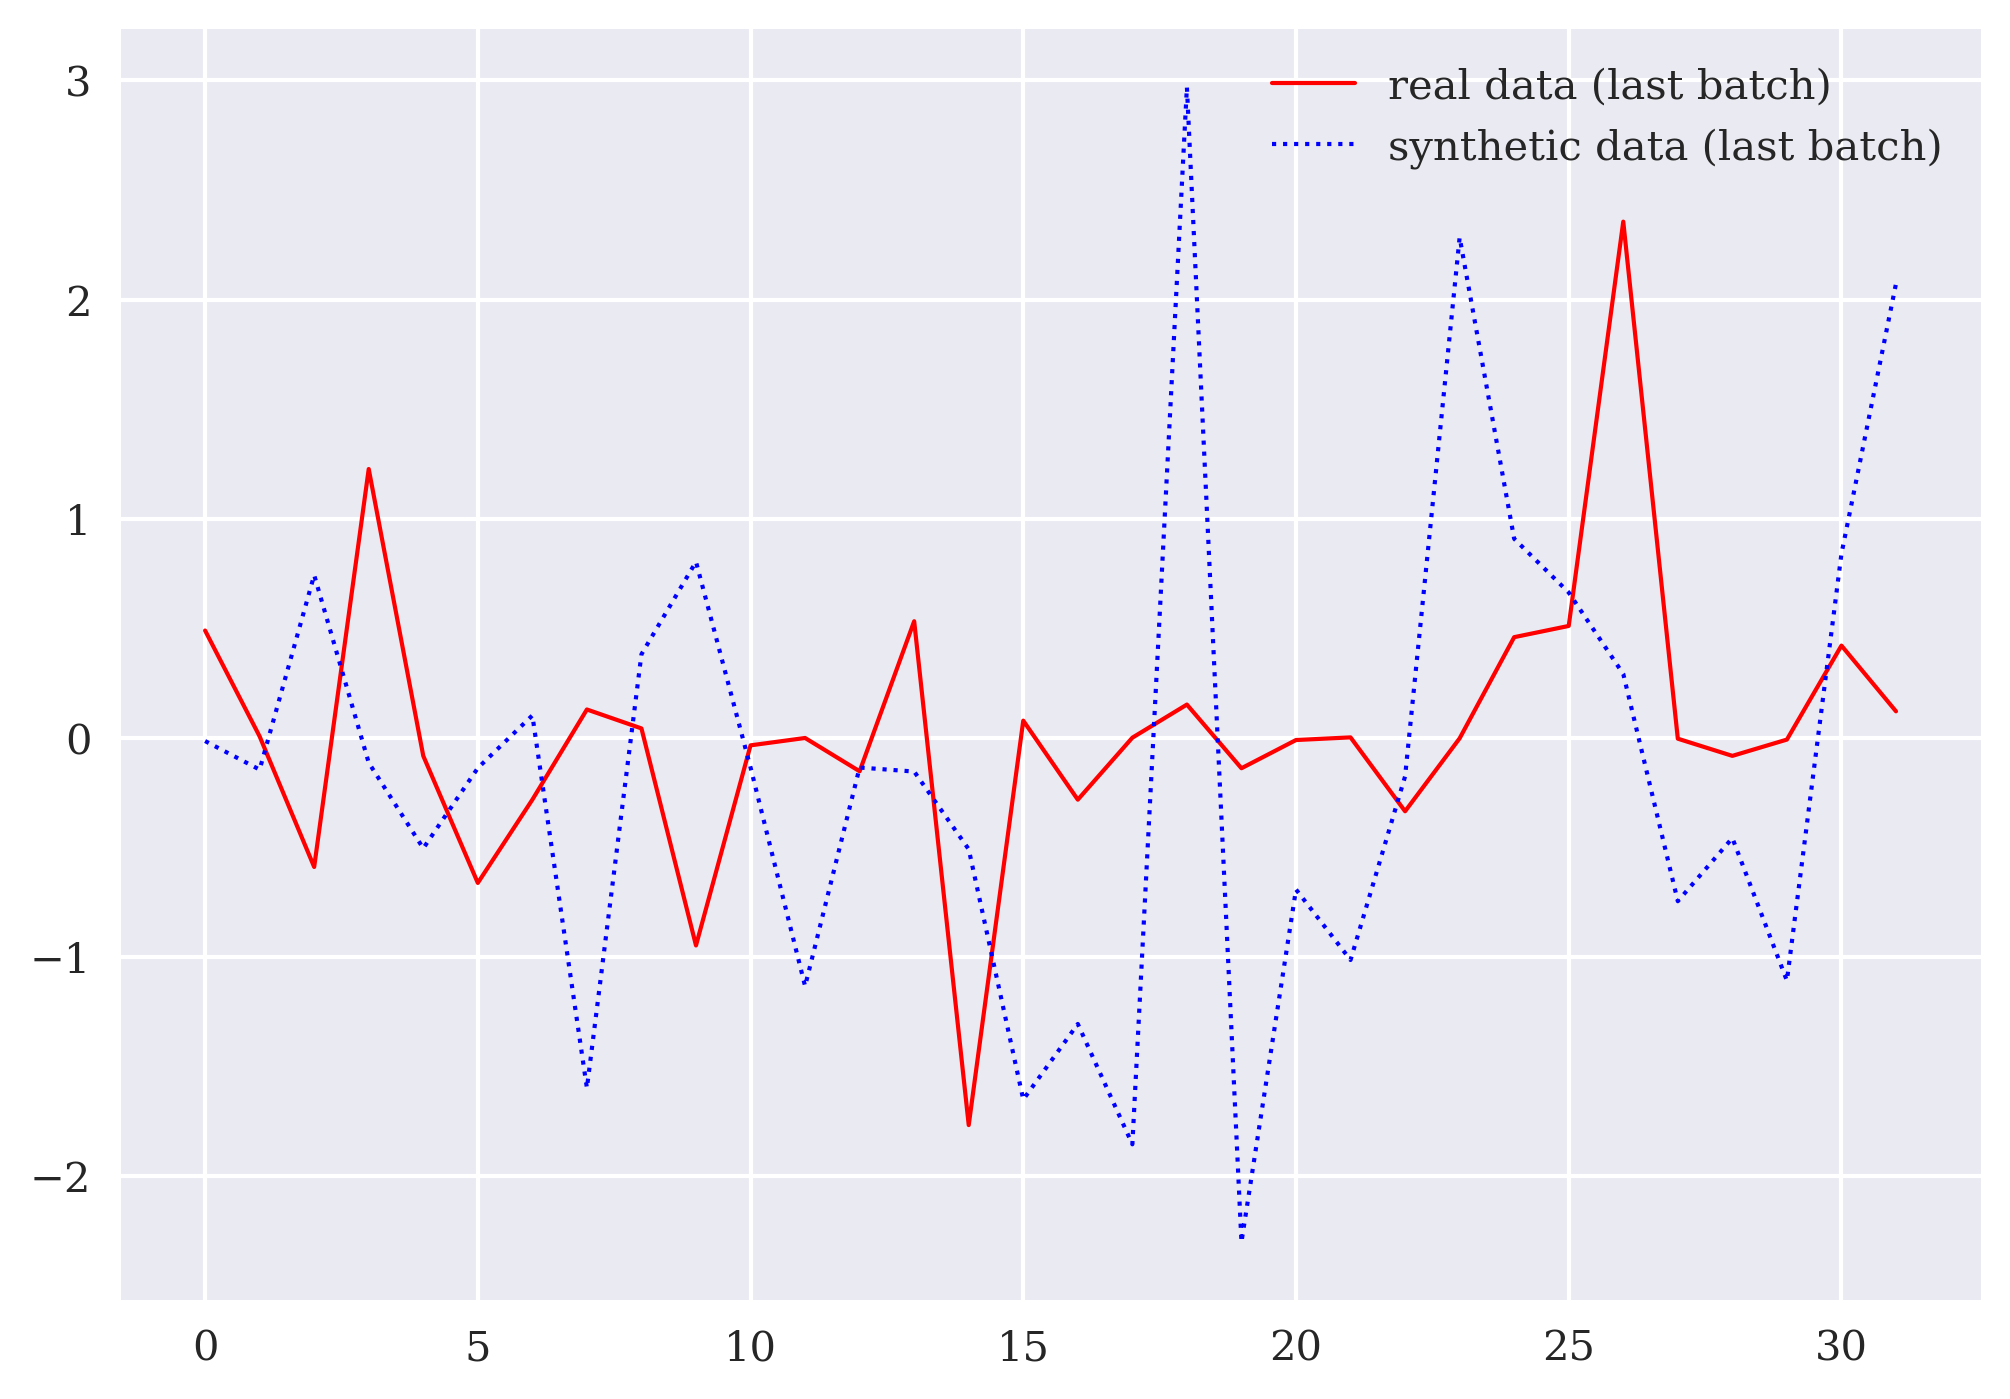

In [18]:
plt.plot(real_data, 'r', lw=1.0,
         label='real data (last batch)')
plt.plot(synthetic_data, 'b:', lw=1.0,
         label='synthetic data (last batch)')
plt.legend();

In [19]:
data = pd.DataFrame({'real': y}, index=x)

In [20]:
N = 5
for i in range(N):
    noise = np.random.normal(0, 1, (len(y), 1))
    noise_t = torch.from_numpy(noise).float()
    synthetic_data = generator(noise_t).detach().numpy()
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)

In [21]:
data.describe().round(3)

,real,synth_00,synth_01,synth_02,synth_03,synth_04
count,500.000,500.000,500.000,500.000,500.000,500.000
mean,-0.000,-0.263,-0.197,-0.425,-0.197,-0.245
std,3.045,3.231,3.067,3.195,3.212,3.051
min,-8.000,-7.429,-8.394,-8.053,-7.987,-7.755
25%,-1.000,-1.119,-1.031,-1.407,-1.330,-1.245
50%,-0.000,-0.410,-0.410,-0.411,-0.411,-0.410
75%,1.000,0.898,1.078,0.237,1.070,0.855
max,8.000,15.291,9.617,11.118,11.353,13.787


In [22]:
((data.apply(np.sort)['real'] -
  data.apply(np.sort)['synth_00']) ** 2).mean()

0.2723470315434426

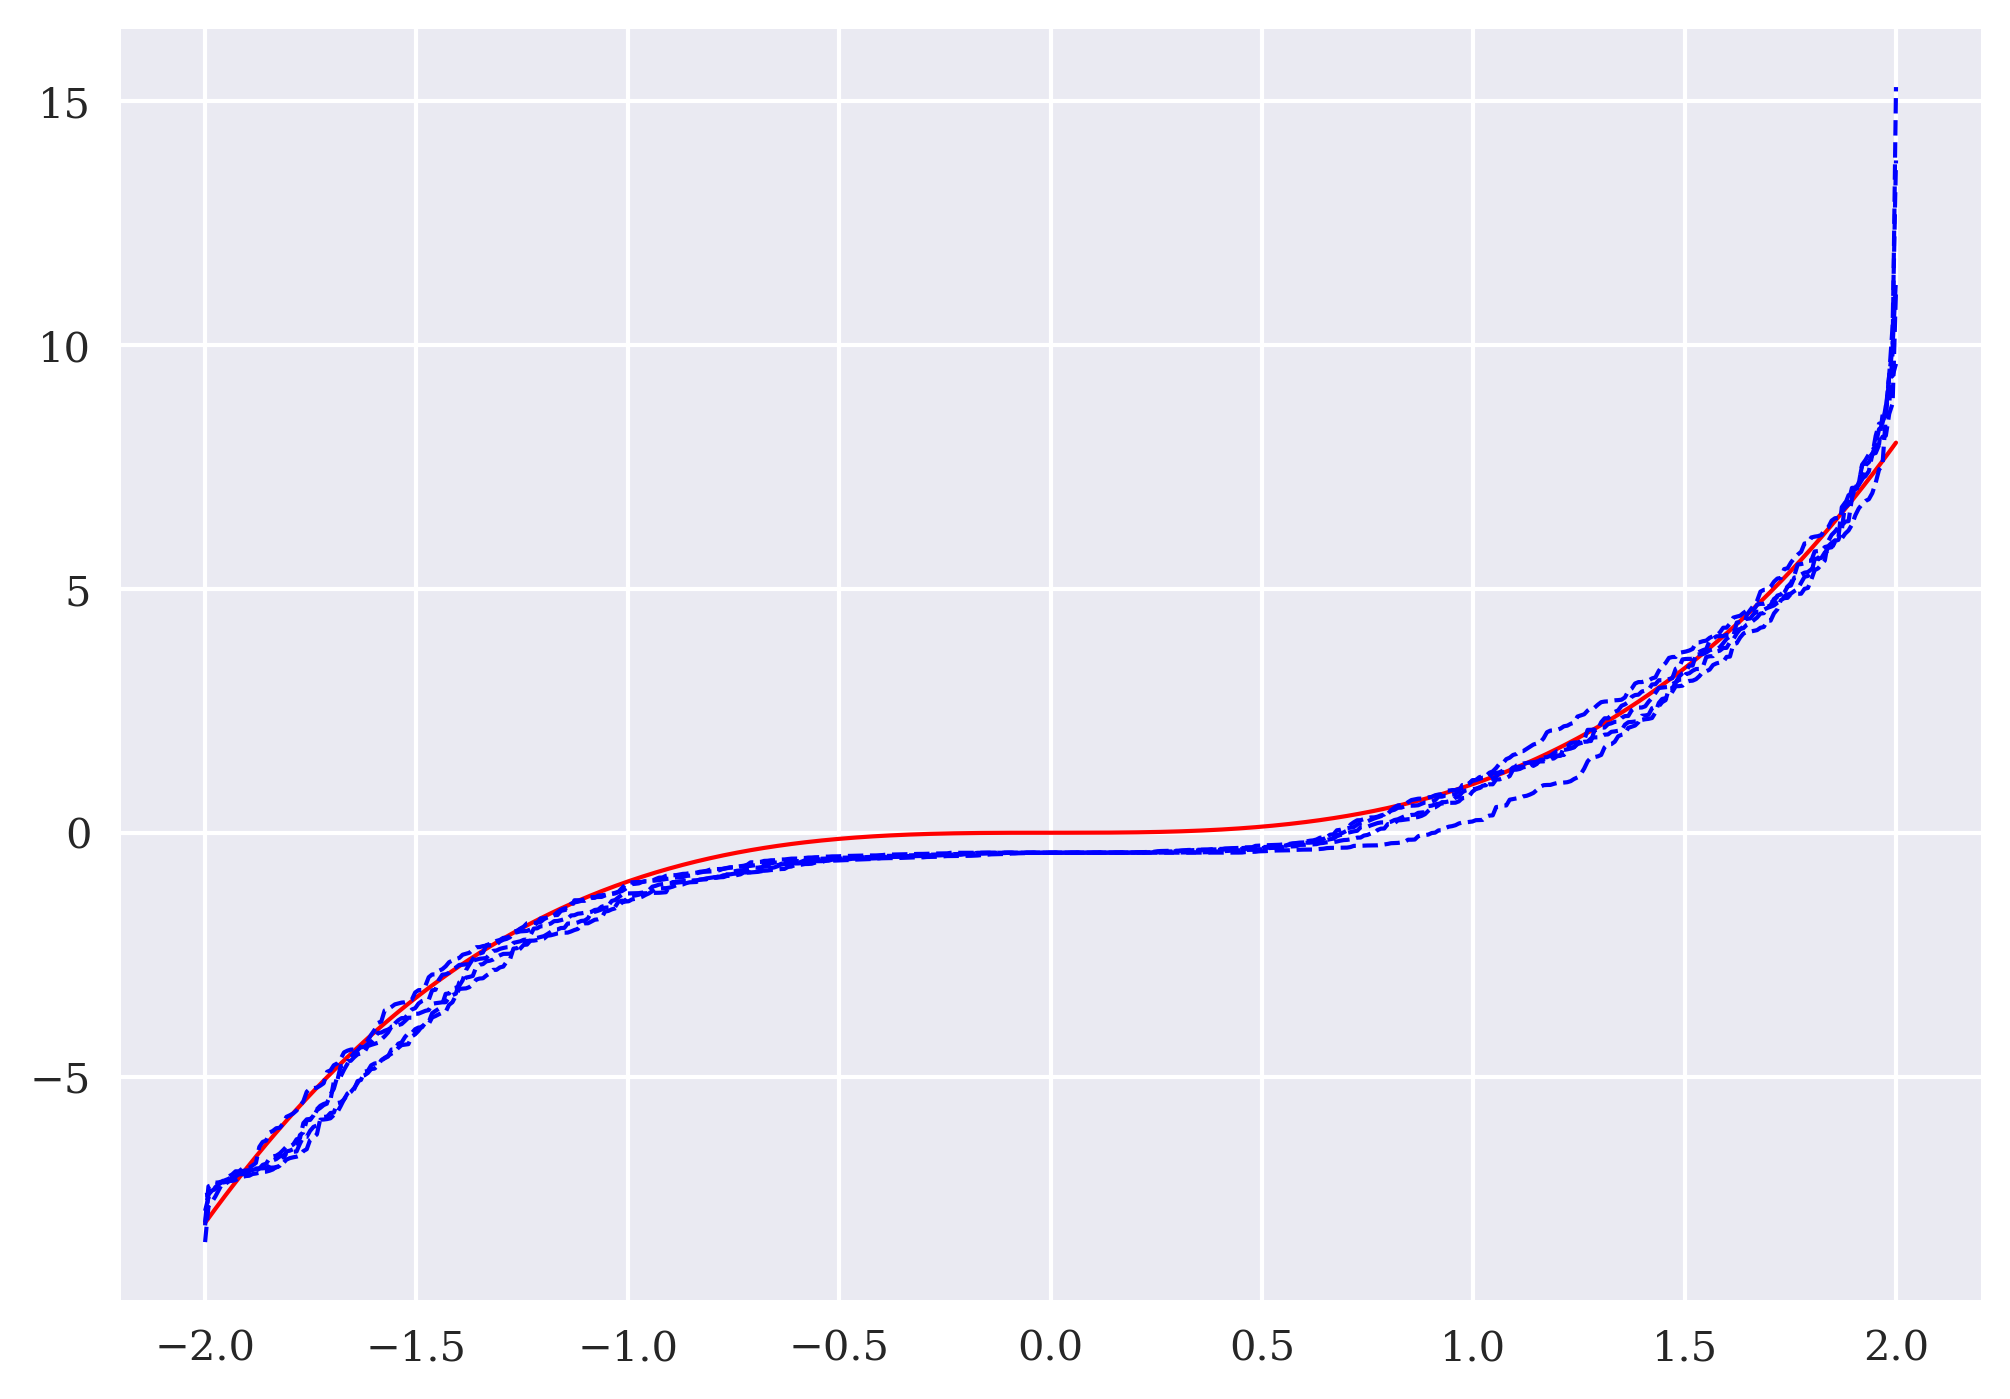

In [23]:
data.apply(np.sort).plot(style=['r'] + N * ['b--'], lw=1, legend=False);

## Financial Example

In [24]:
raw = pd.read_csv('https://certificate.tpq.io/rl4finance.csv',
                 index_col=0, parse_dates=True).dropna()

In [25]:
rets = raw['GLD'].iloc[-2 * 252:]
rets = np.log((rets / rets.shift(1)).dropna())
rets = rets.values

In [26]:
scaler = StandardScaler()

In [27]:
rets_ = scaler.fit_transform(rets.reshape(-1, 1))

In [28]:
rng = default_rng(seed=100)
torch.manual_seed(100)

In [29]:
generator = Generator(hu=24)
discriminator = Discriminator(hu=24)
gen_optimizer, disc_optimizer, criterion = create_gan(generator, discriminator, lr=0.0001)

In [30]:
%time rd, sd = train_models(y_=rets_, epochs=15001, batch_size=32)

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
Epoch: 6000
Epoch: 7000
Epoch: 8000
Epoch: 9000
Epoch: 10000
Epoch: 11000
Epoch: 12000
Epoch: 13000
Epoch: 14000
Epoch: 15000
CPU times: total: 35.4 s
Wall time: 43.9 s


In [31]:
data = pd.DataFrame({'real': rets})

In [32]:
N = 25

In [33]:
for i in range(N):
    noise = np.random.normal(0, 1, (len(rets_), 1))
    noise_t = torch.from_numpy(noise).float()
    synthetic_data = generator(noise_t).detach().numpy()
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)

In [34]:
res = data.describe().round(4)
res.iloc[:, :5]

,real,synth_00,synth_01,synth_02,synth_03
count,503.0000,503.0000,503.0000,503.0000,503.0000
mean,0.0002,0.0048,0.0048,0.0046,0.0048
std,0.0090,0.0086,0.0082,0.0082,0.0082
min,-0.0302,-0.0160,-0.0167,-0.0154,-0.0159
25%,-0.0052,-0.0010,-0.0009,-0.0009,-0.0011
50%,0.0003,0.0040,0.0040,0.0038,0.0043
75%,0.0054,0.0087,0.0091,0.0087,0.0087
max,0.0316,0.0419,0.0344,0.0536,0.0343


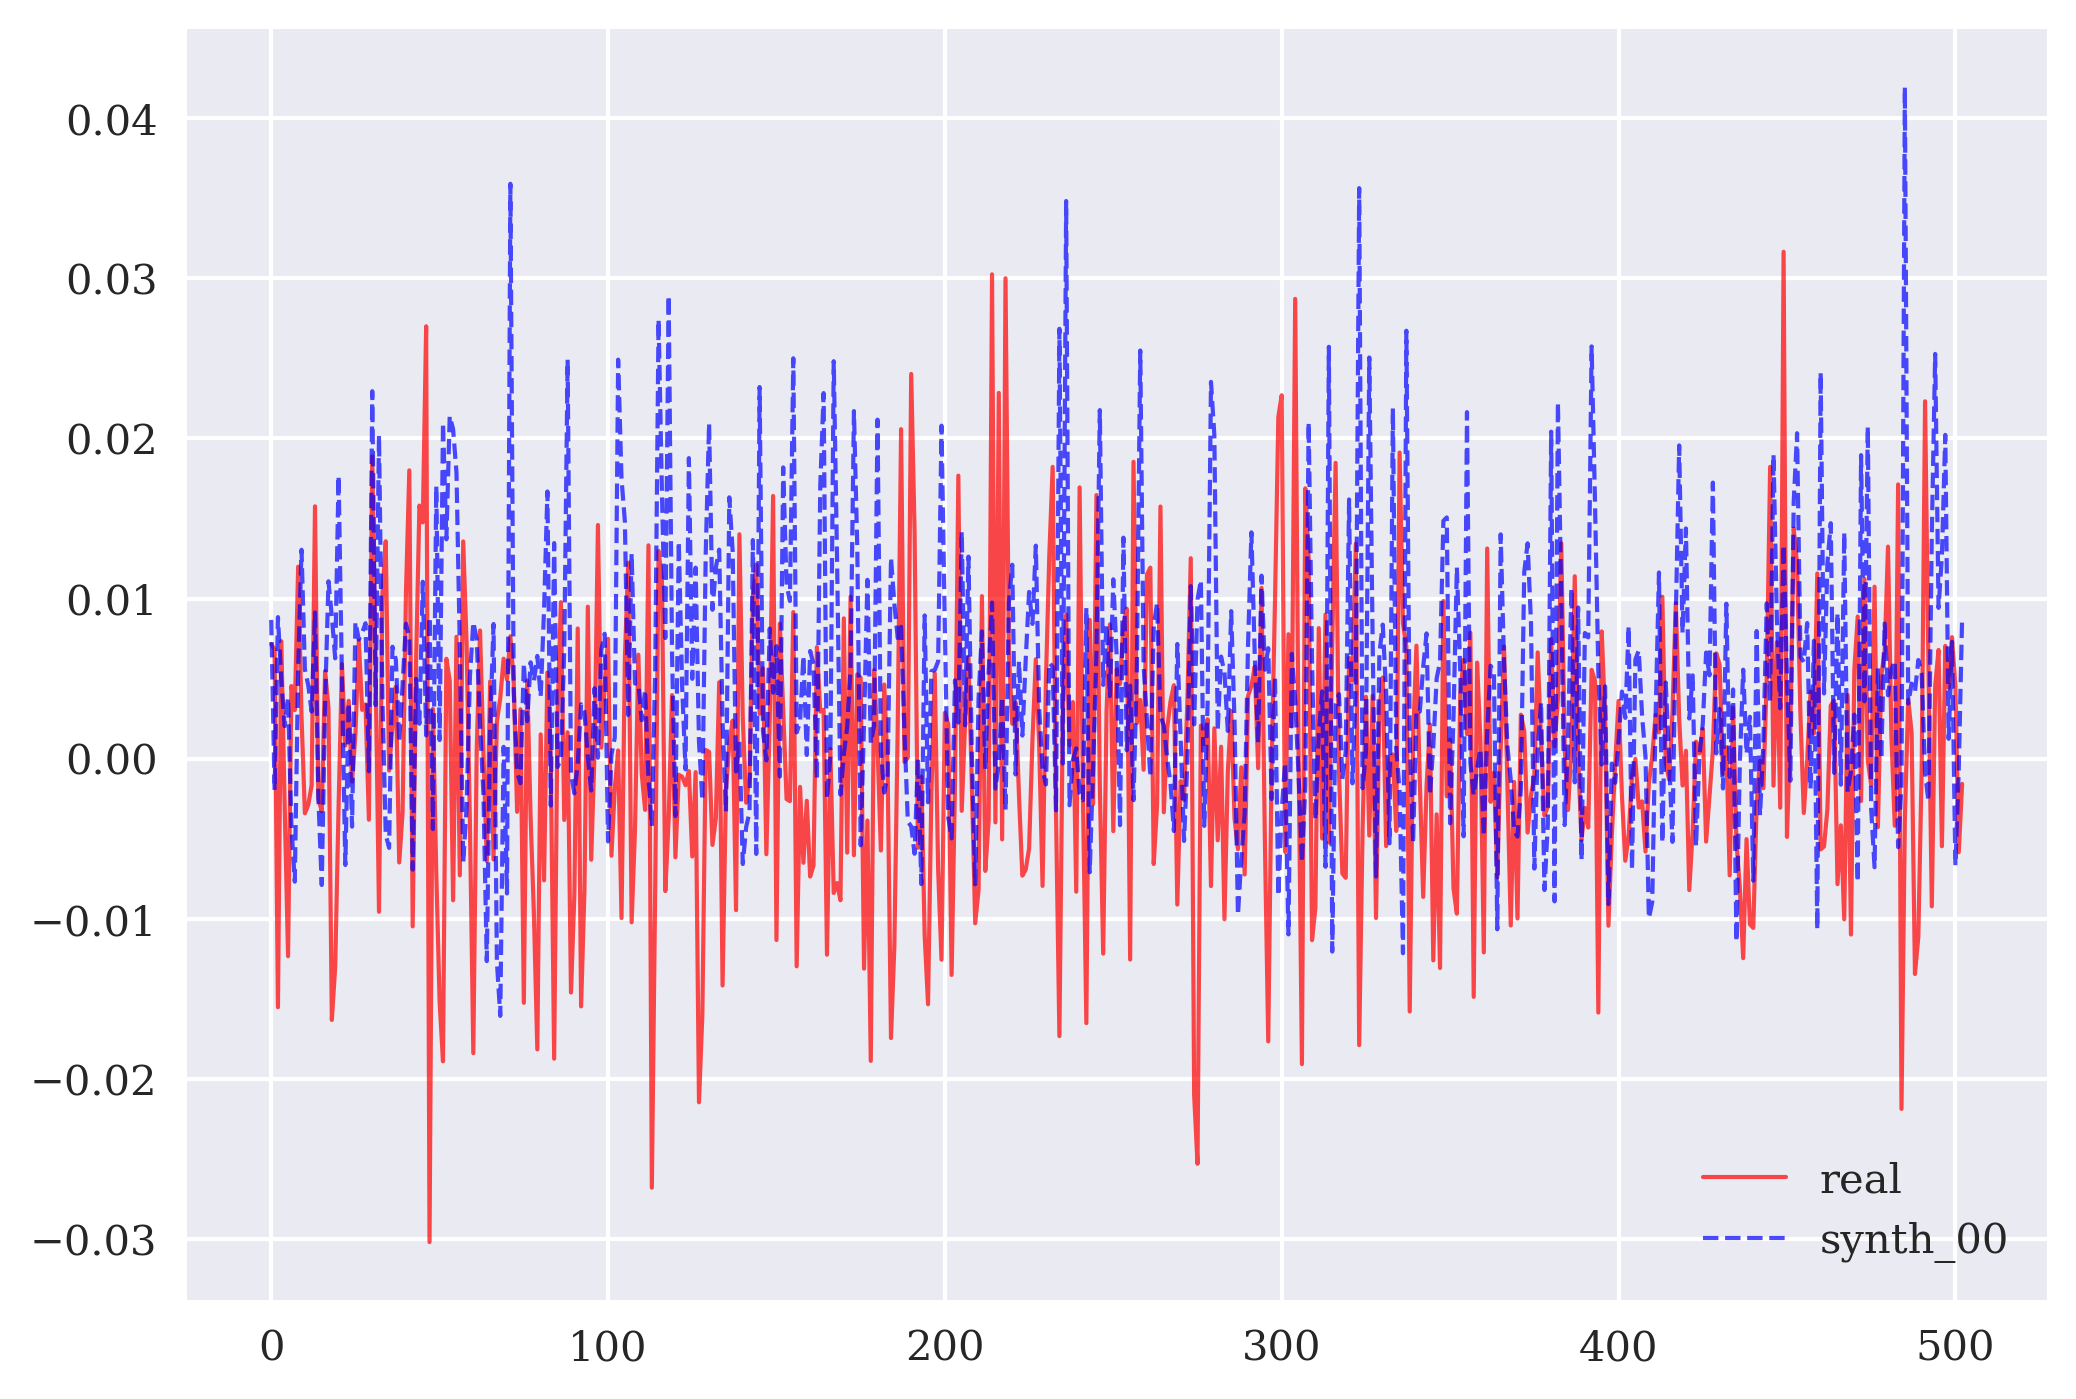

In [35]:
data.iloc[:, :2].plot(style=['r', 'b--', 'b--'], lw=1, alpha=0.7);

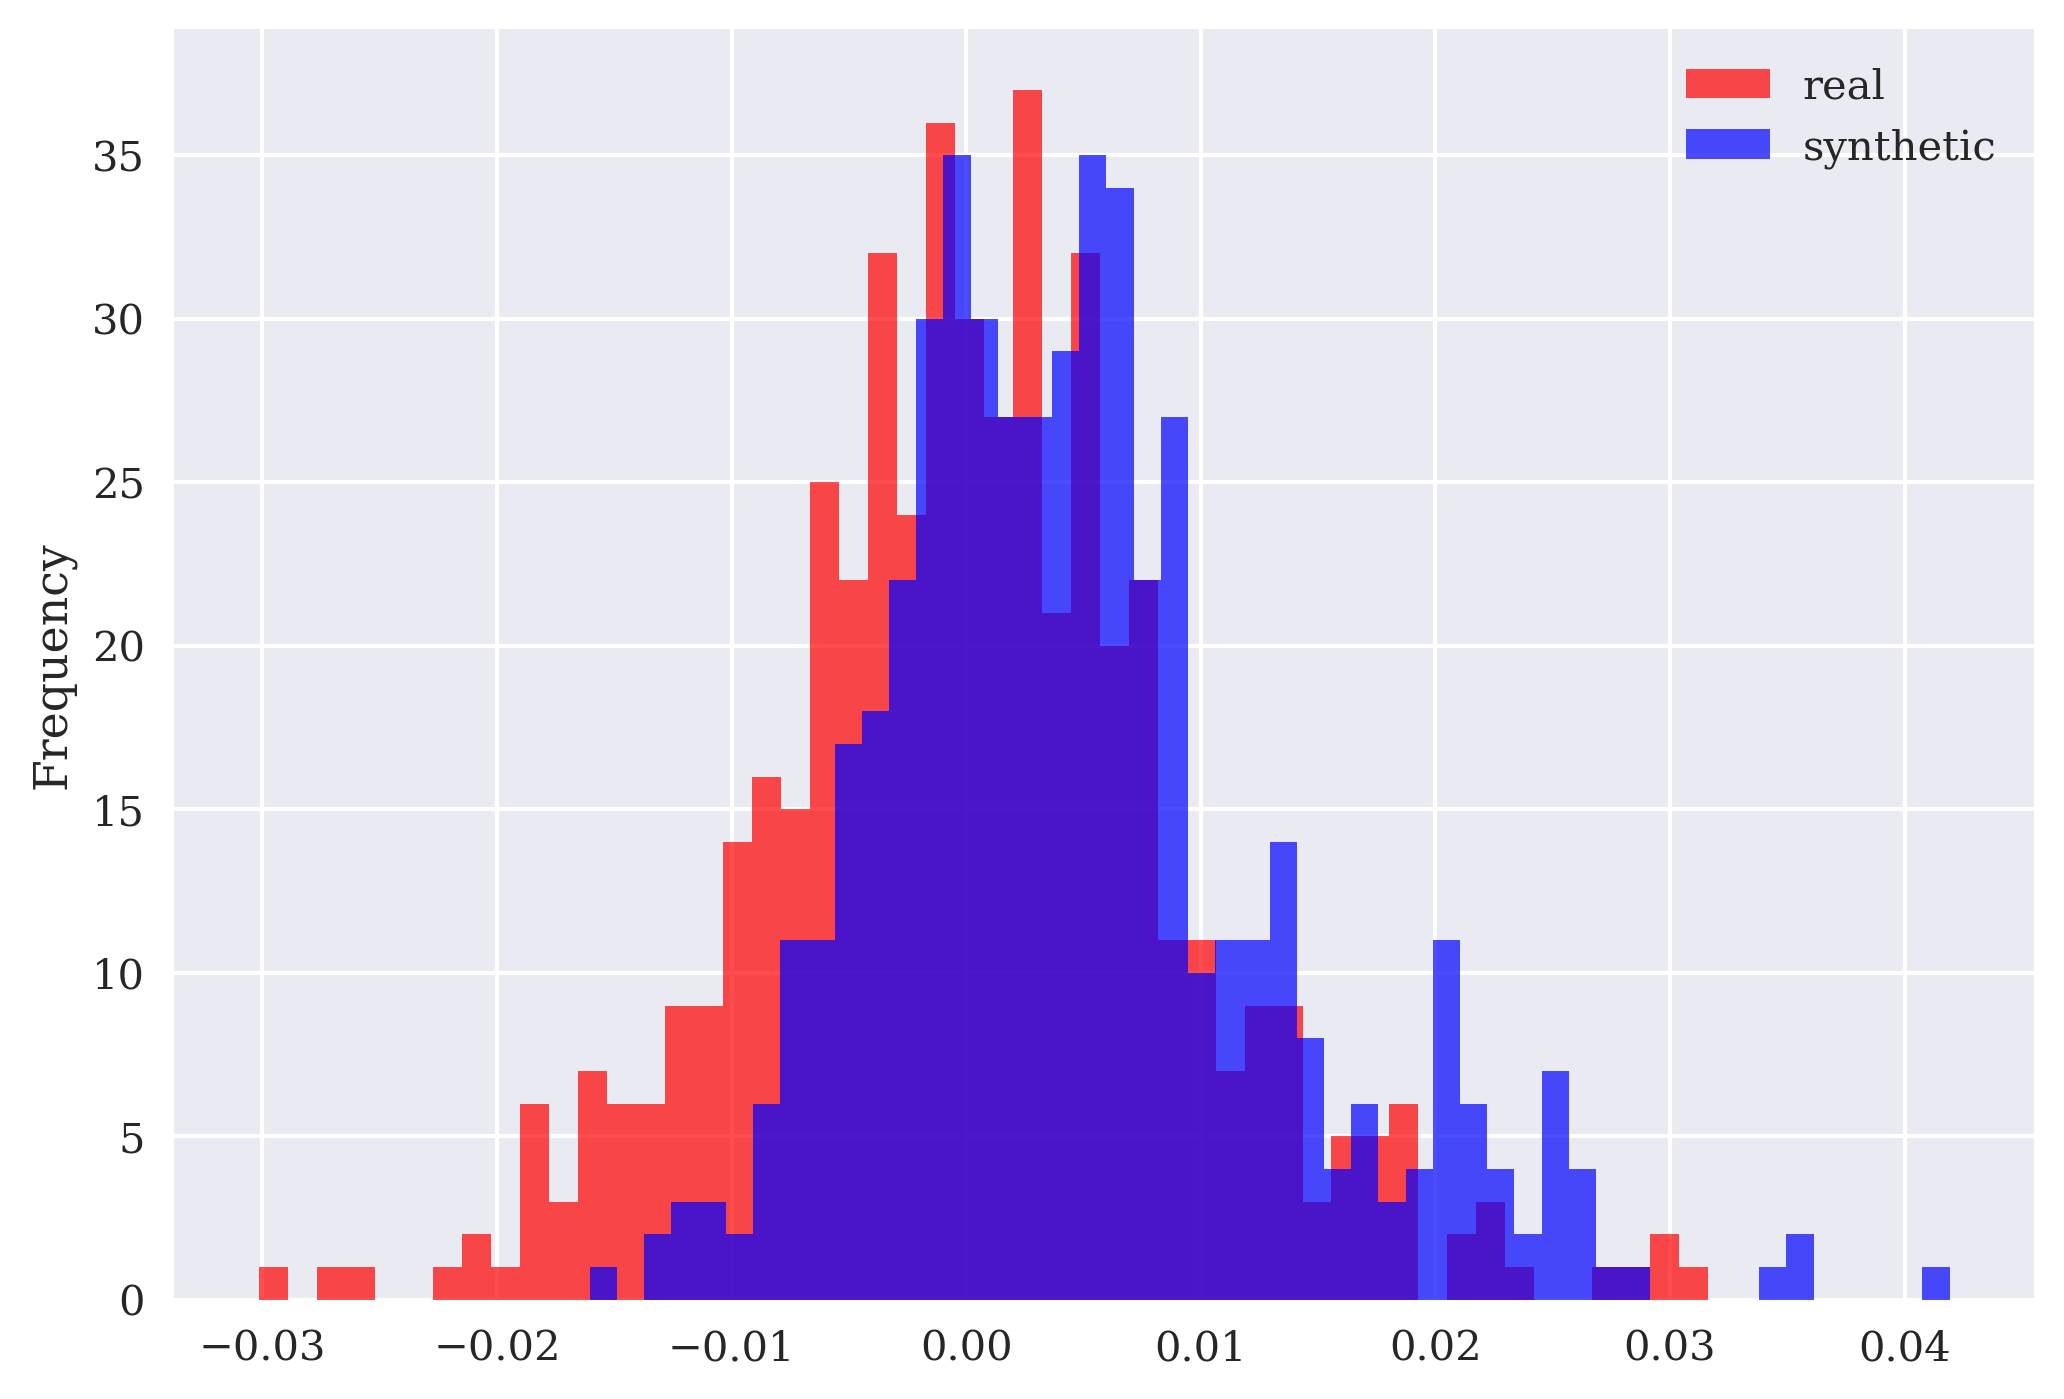

In [36]:
data['real'].plot(kind='hist', bins=50, label='real',
                  color='r', alpha=0.7)
data['synth_00'].plot(kind='hist', bins=50, alpha=0.7,
                  label='synthetic', color='b', sharex=True)
plt.legend();

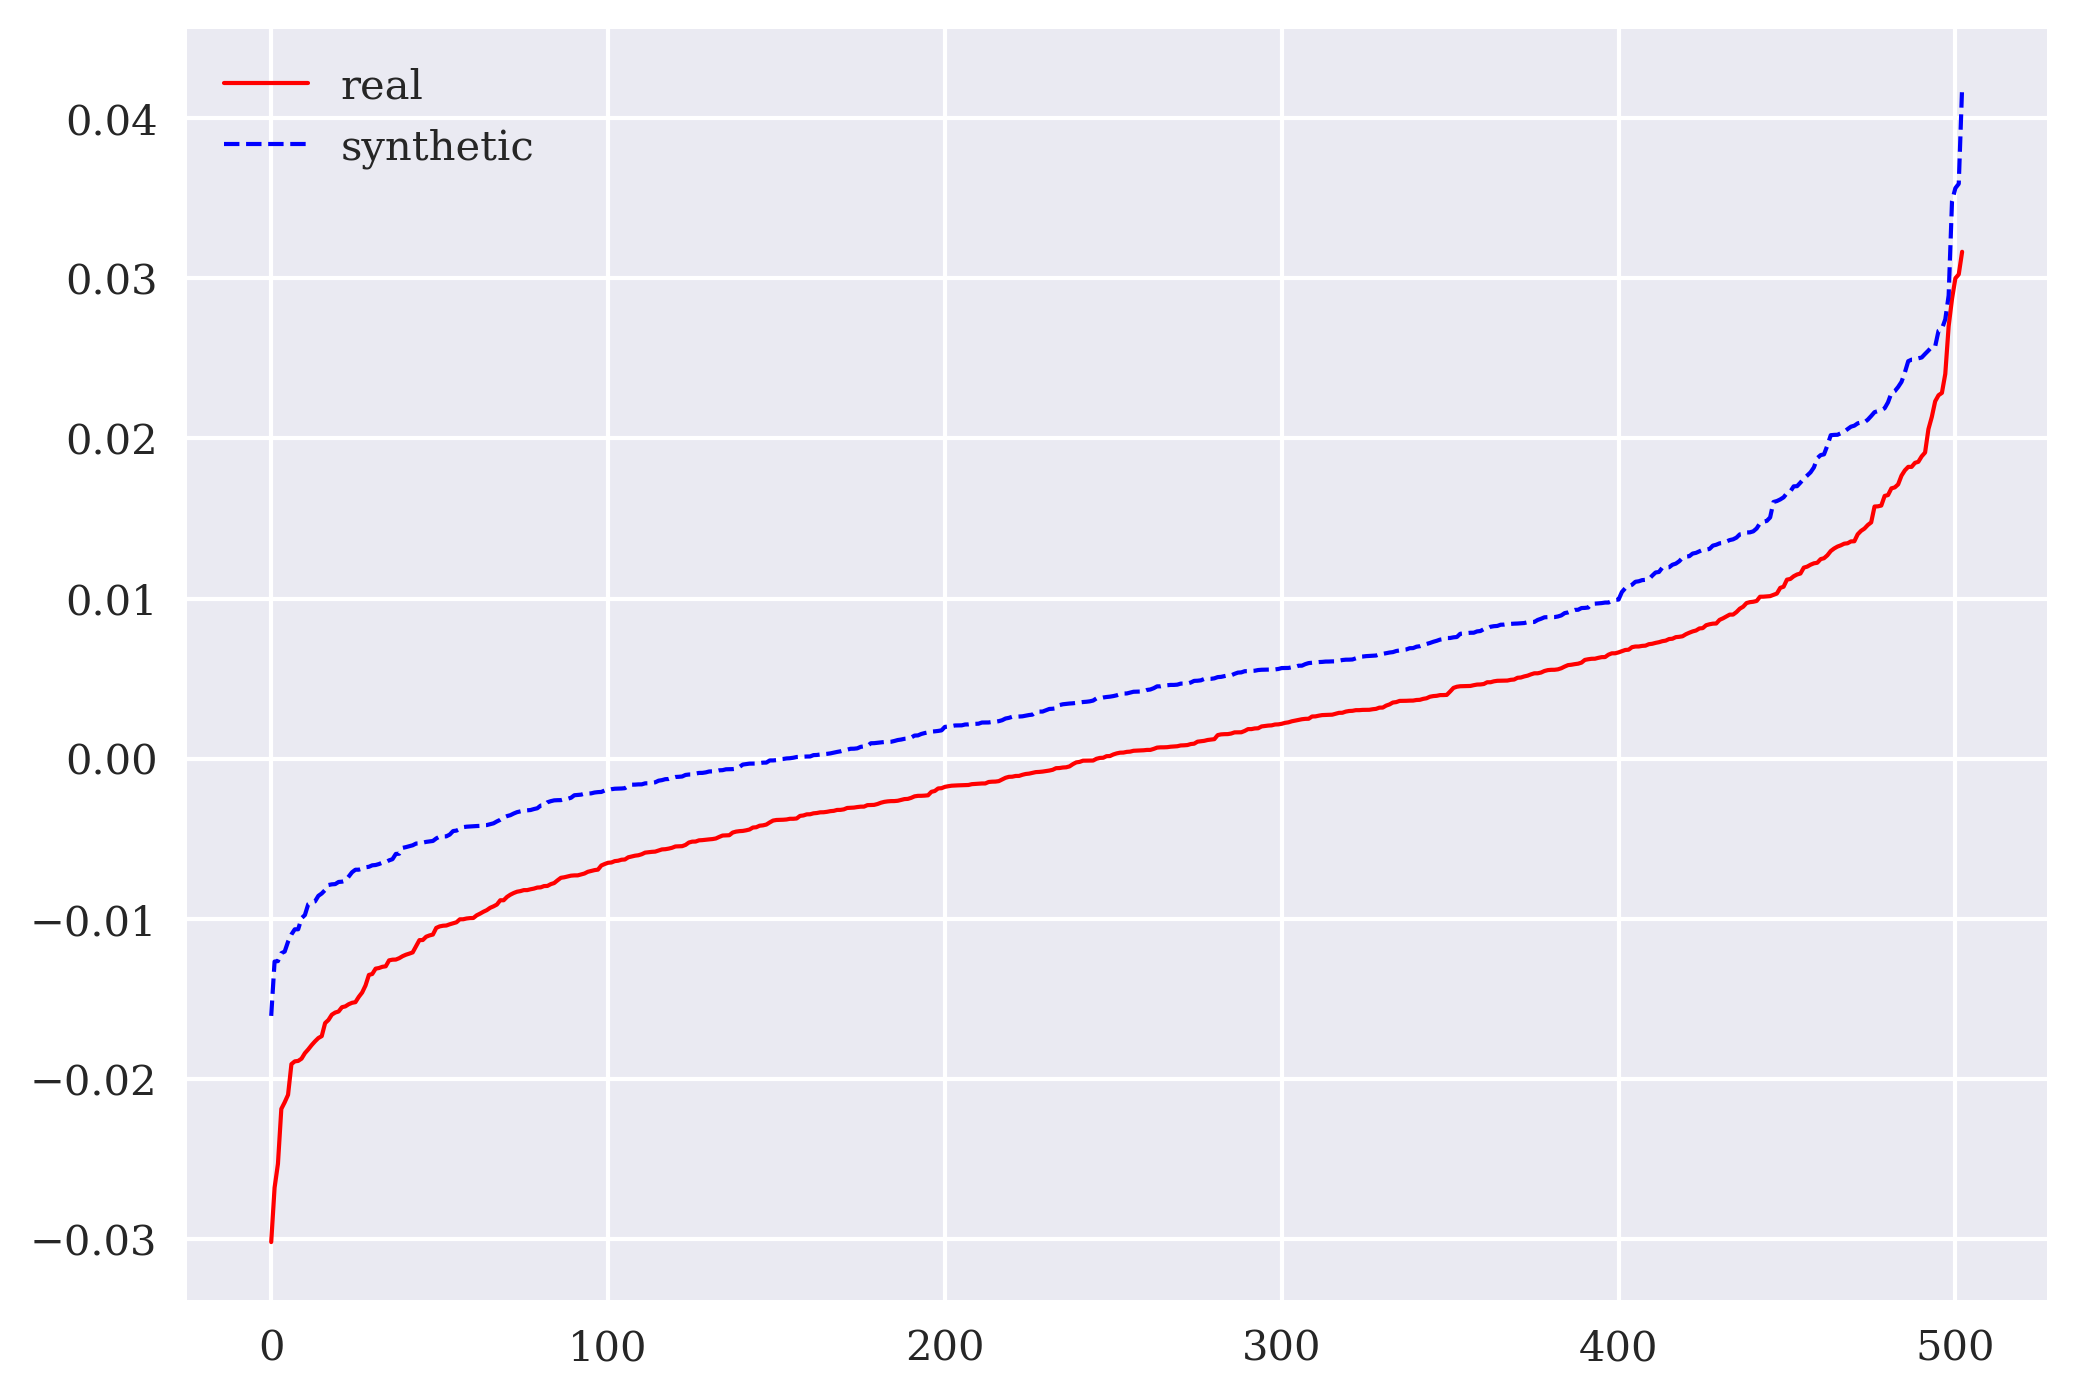

In [37]:
plt.plot(np.sort(data['real']), 'r', lw=1.0, label='real')
plt.plot(np.sort(data['synth_00']), 'b--', lw=1.0, label='synthetic')
plt.legend();

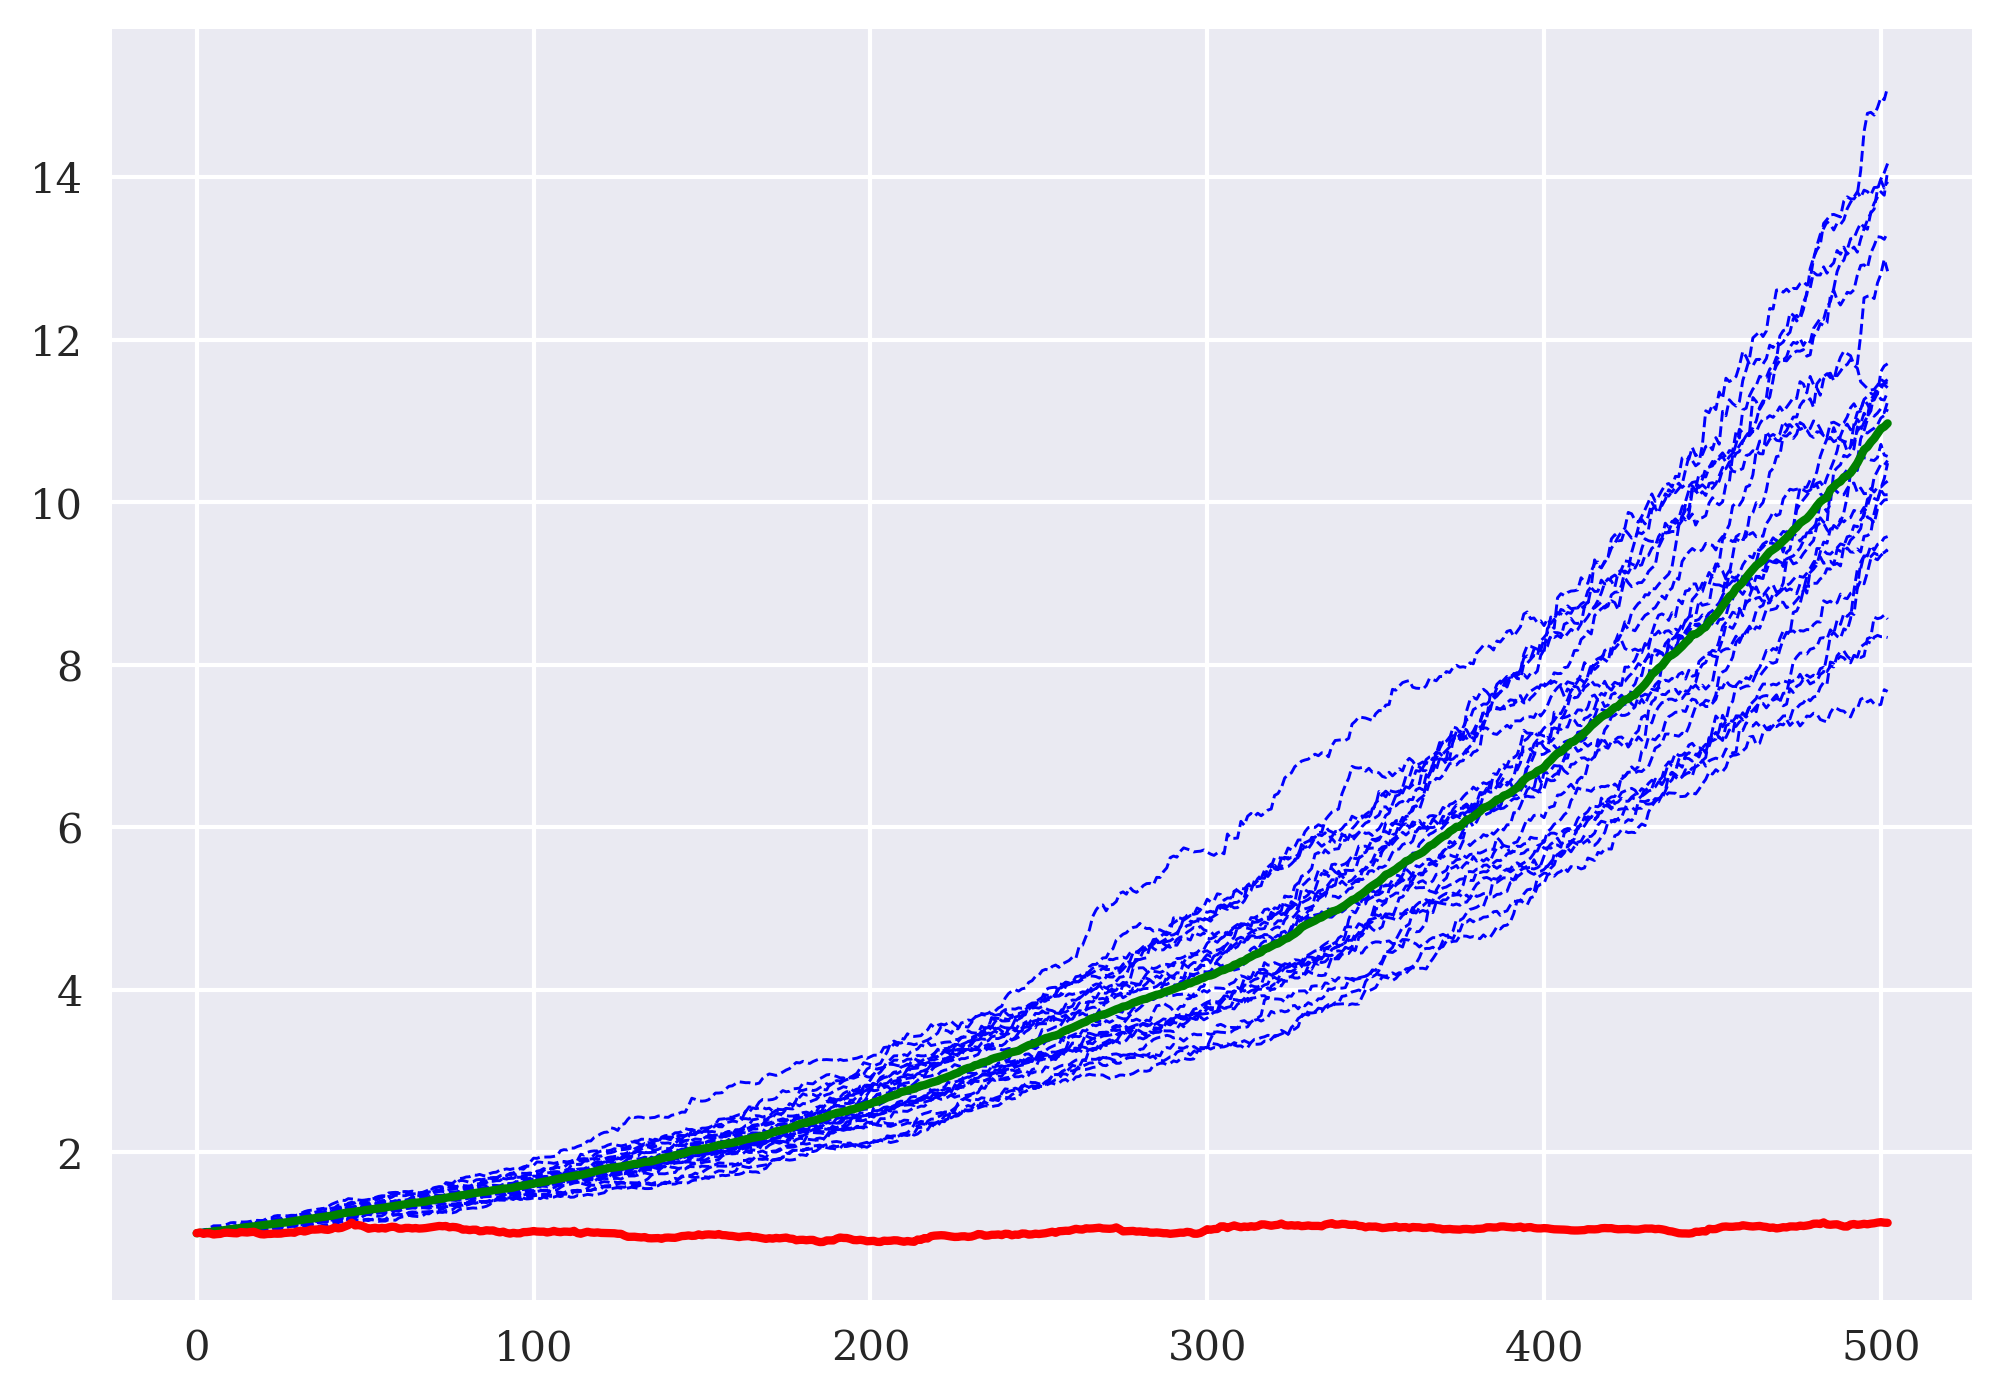

In [38]:
sn = N
data.iloc[:, 1:sn + 1].cumsum().apply(np.exp).plot(
    style='b--', lw=0.7, legend=False)
data.iloc[:, 1:sn + 1].mean(axis=1).cumsum().apply(
    np.exp).plot(style='g', lw=2)
data['real'].cumsum().apply(np.exp).plot(style='r', lw=2);

### Kolmogorow-Smirnow (KS) Test

In [39]:
from scipy import stats

In [40]:
pvs = list()
for i in range(N):
    pvs.append(stats.kstest(data[f'synth_{i:02d}'],
                            data['real']).pvalue)
pvs = np.array(pvs)

In [41]:
np.sort((pvs > 0.05).astype(int))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [42]:
sum(np.sort(pvs > 0.05)) / N

0.0

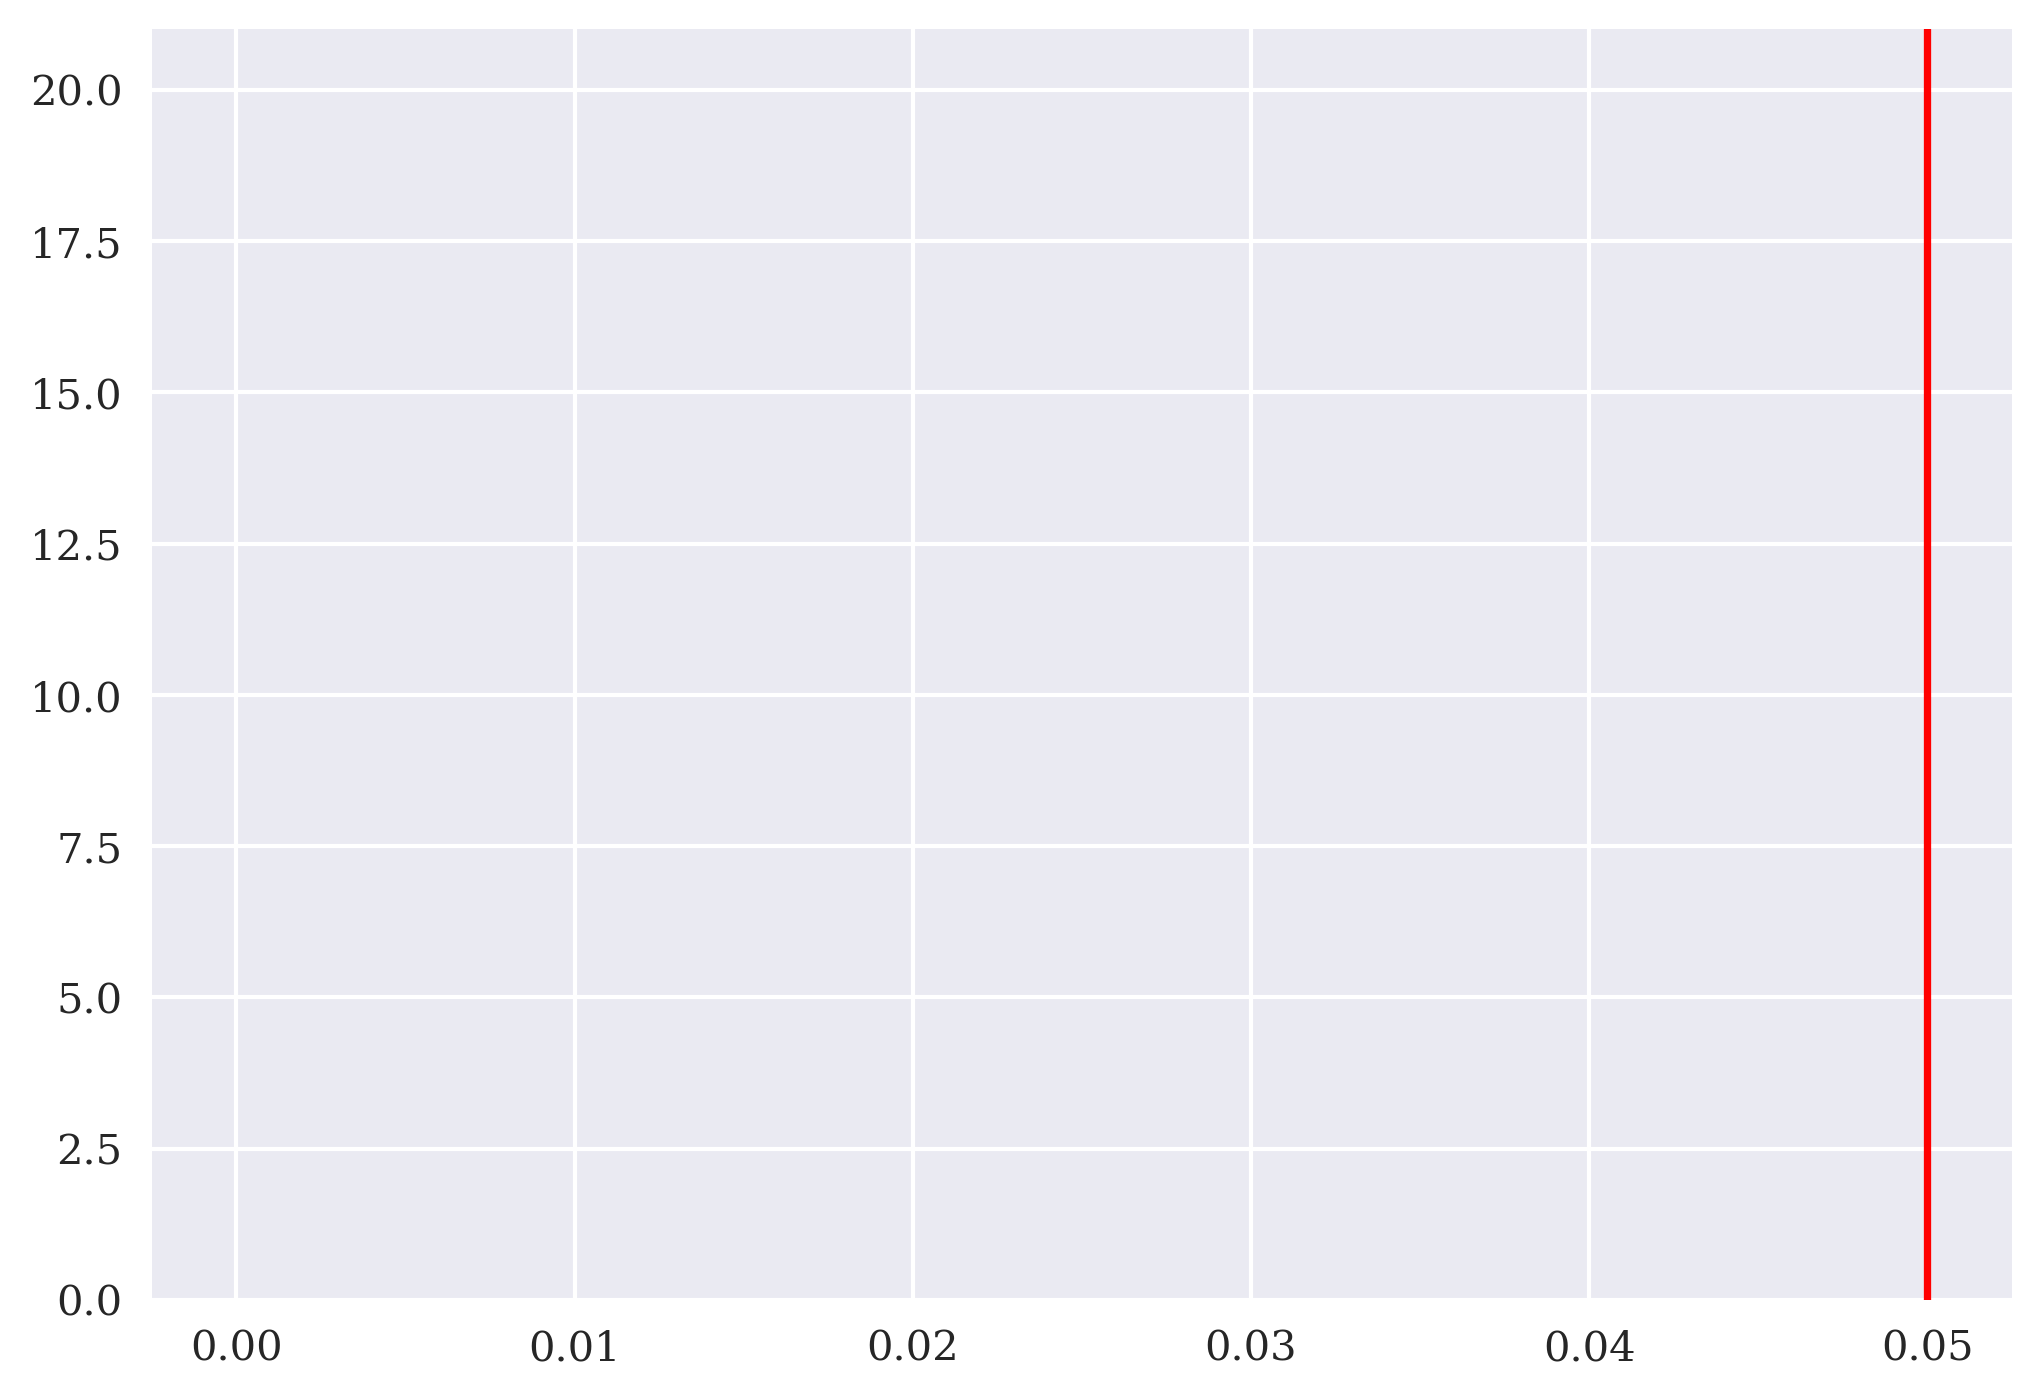

In [43]:
plt.hist(pvs, bins=100)
plt.axvline(0.05, color='r');

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>